In [ ]:
#| default_exp opt

In [ ]:
from translucid.opt import *
import torch.optim as opt
import torch, torch.nn as nn
import torch.nn.functional as F
from fastprogress import progress_bar
import fastcore.all as fc
from torchvision import models
import matplotlib.pyplot as plt
import torchvision.transforms as T

In [ ]:
#| export
def to_cpu(x):
    if isinstance(x, (list, tuple)):
        return [to_cpu(o) for o in x]
    return x.detach().cpu()

In [ ]:
class Visualizer:
    def __init__(self, model, obj, target, optim=opt.Adam, tfms=None):
        self.model, self.obj, self.target, self.optim = model, obj, target, optim
        self.tfms = tfms or fc.noop
    
    def visualize(self, x = None, lr = 5e-2, n_iter = 1000):
        x = fc.ifnone(x, self.target)
        optim = self.optim([x], lr=lr)
        # lr_sched = opt.lr_scheduler.OneCycleLR(optim, lr, n_iter)
        pb = progress_bar(range(n_iter))
        for i in pb:
            optim.zero_grad()
            loss = self.obj(self.model, self.tfms(x))
            loss.backward()
            optim.step()
            # lr_sched.step()
            pb.comment = f'Loss: {loss.item()/len(x)}'
            if i % 100 == 0:
                print(f'Iteration {i}, loss: {loss.item()/len(x)}')
        return x

In [ ]:
layer = 'inception4b'
model = models.googlenet(weights='IMAGENET1K_V1')
model = model.eval()

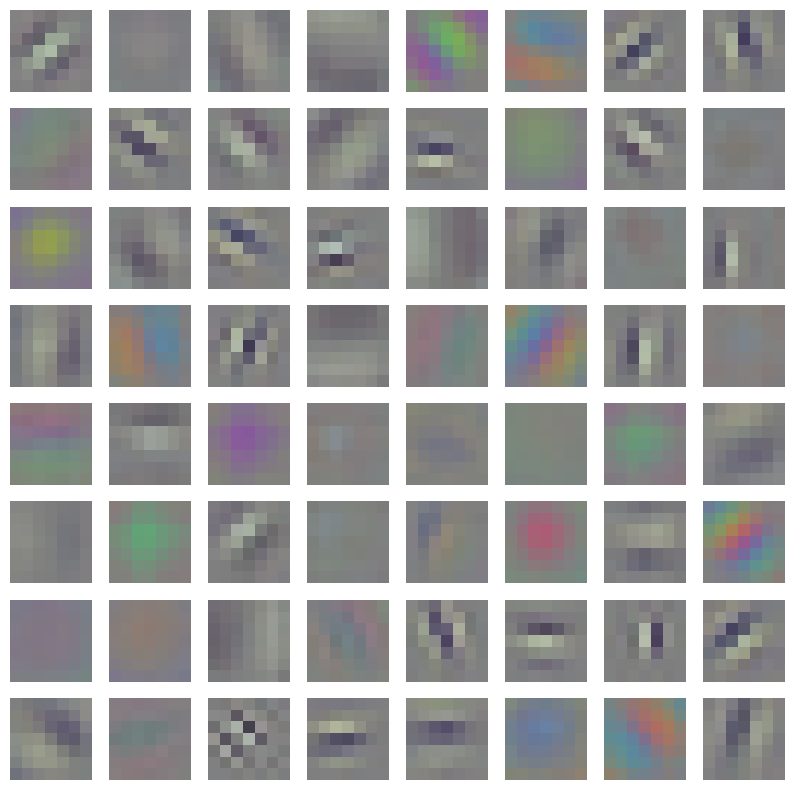

In [ ]:
axes = plt.subplots(8, 8, figsize=(10, 10))[1]
for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    ax.imshow(torch.sigmoid(to_cpu(model.conv1.conv.weight[i])).permute(1, 2, 0))

In [ ]:
from lucent import modelzoo
layer = 'mixed3a'
model = modelzoo.inceptionv1(pretrained=True)
model = model.eval()

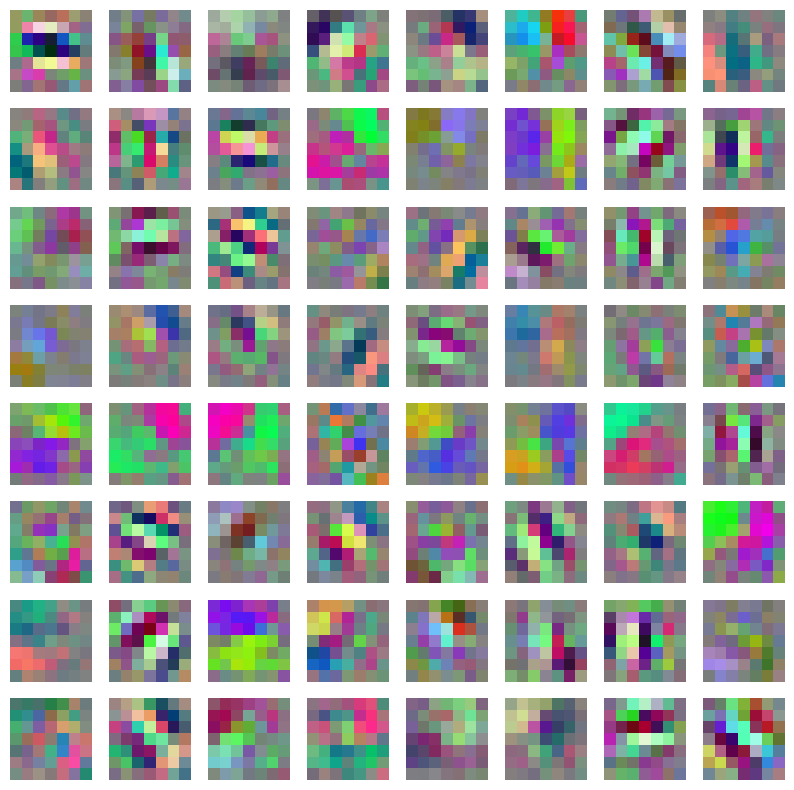

In [ ]:
axes = plt.subplots(8, 8, figsize=(10, 10))[1]
for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    ax.imshow(torch.sigmoid(to_cpu(model.conv2d0_pre_relu_conv.weight[i])).permute(1, 2, 0))

In [ ]:
obj = sum(channel(layer, i, batch=i) for i in range(10))

In [ ]:
def to_valid_rgb(img):
    return torch.sigmoid(img)

def to_inception_tf(img): return to_valid_rgb(img) * 255 - 117

def to_inception(img, tf=False):
    if tf: return to_valid_rgb(img) * 255 - 117
    t = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return t(to_valid_rgb(img))

In [ ]:
x = torch.randn(10, 3, 224,224)*0.01
x.requires_grad_(True)
vis = Visualizer(model, obj, x, tfms = to_inception)

In [ ]:
res = vis.visualize(n_iter=100)

Iteration 0, loss: -15.938041687011719


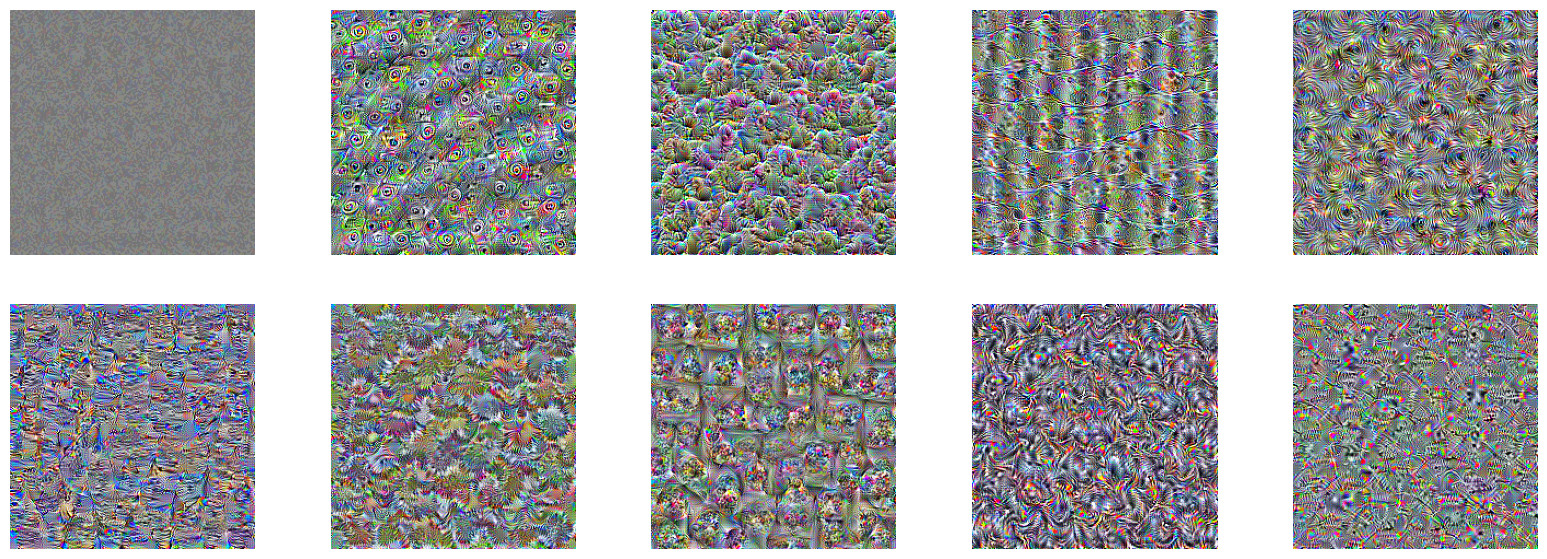

In [ ]:
axes = plt.subplots(2,5, figsize=(20, 7))[1]
for i,ax in enumerate(axes.flatten()):
    ax.axis('off')
    im = to_valid_rgb(to_cpu(res[i])).permute(1, 2, 0)
    ax.imshow(im)   

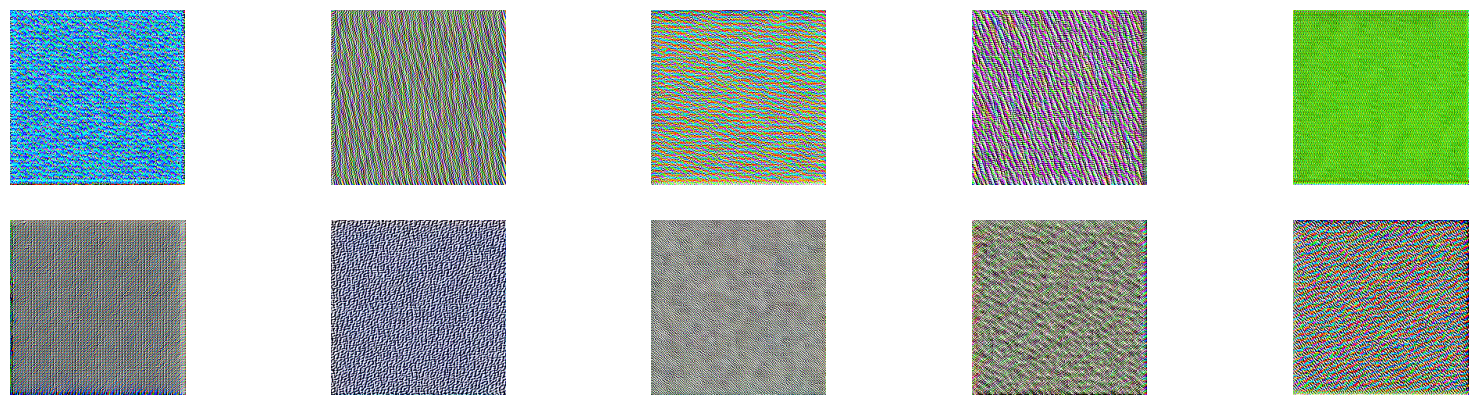

In [ ]:
axes = plt.subplots(2,5, figsize=(20, 5))[1]
for i,ax in enumerate(axes.flatten()):
    ax.axis('off')
    im = to_valid_rgb(to_cpu(res[i])).permute(1, 2, 0)
    ax.imshow(im)   

In [ ]:
model.mixed4b

CatLayer()

In [ ]:
model = modelzoo.inceptionv1(pretrained=True)
obj = channel('mixed4b', 452)
x = torch.randn(1, 3, 224,224)*0.01
x.requires_grad_(True)
res = Visualizer(model, obj, x, tfms = to_inception_tf).visualize(n_iter=512)

Iteration 0, loss: -45.72288513183594
Iteration 100, loss: -7971.14599609375
Iteration 200, loss: -8934.3359375
Iteration 300, loss: -9400.8740234375
Iteration 400, loss: -9657.2216796875
Iteration 500, loss: -9841.2041015625


<matplotlib.image.AxesImage>

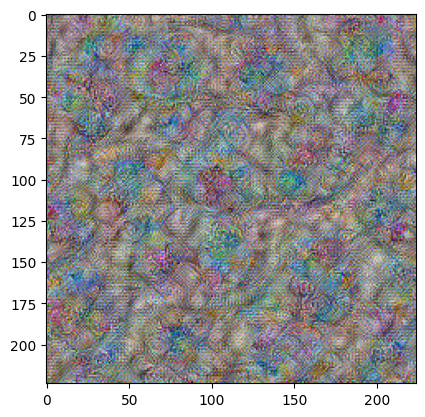

In [ ]:
plt.imshow(to_cpu(to_valid_rgb(res[0])).permute(1, 2, 0))